In [1]:
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
import nibabel as nib
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import load, savez_compressed
from natsort import natsorted

from preprocess.get_subvolume import get_training_sub_volumes, get_test_subvolumes


dataset_folder = "/media/bersek/56DAFC88DAFC65A1/BRATS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

In [2]:
print(tf.__version__)
tf.config.list_physical_devices("GPU") 

2.6.0


2021-10-14 20:37:15.914009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 20:37:15.985505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 20:37:15.985834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def make_dirs(volumes_paths):
    processed_paths = {}
    processed_sample_paths = {}
    SAMPLES_FOLDERS = volumes_paths
    PARENT_DIR = os.getcwd()
    ANTER = os.path.abspath(os.path.join(os.path.dirname(PARENT_DIR), '.'))
    processed_paths["ANTER"] = ANTER
    DATABASE_DIR = os.path.join(ANTER, "BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

    processed_paths["PROCESSED_DIR"] = os.path.join(ANTER, "processed")
    PROCESSED_DIR = processed_paths["PROCESSED_DIR"]

    processed_paths["3D"] = os.path.join(PROCESSED_DIR, "3D")
    UNET_3D = processed_paths["3D"]

    processed_paths["SUBVOLUME_FOLDER"] = os.path.join(UNET_3D,"subvolumes")
    processed_paths["SUBVOLUME_MASK_FOLDER"] = os.path.join(UNET_3D,"subvolumes_masks")
    processed_paths["ROTATION_MATRIX"] = os.path.join(UNET_3D,"rotation_matrix")
    processed_paths["RESULTS_3D"] = os.path.join(UNET_3D,"subvolumes_predict")

    for path in processed_paths:
        dir_exists = os.path.exists(processed_paths[path])
        if not dir_exists:
            os.makedirs(processed_paths[path])

    processed_paths.pop("PROCESSED_DIR")
    processed_paths.pop("ANTER")
    processed_paths.pop("3D")
    for path in processed_paths:
        if path == "RESULTS_3D":
            train_files, val_files = train_test_split(SAMPLES_FOLDERS, test_size=0.2, random_state=42)
            test_files, val_files = train_test_split(val_files, test_size=0.5, random_state=42)
            SAMPLES_FOLDERS_TEST_TRAIN = test_files
            TEST_SAMPLES = SAMPLES_FOLDERS_TEST_TRAIN
        else:
            SAMPLES_FOLDERS_TEST_TRAIN = SAMPLES_FOLDERS

        for sample in SAMPLES_FOLDERS_TEST_TRAIN:
            sample_dir = os.path.join(processed_paths[path], sample)
            dir_exists = os.path.exists(sample_dir)
            if not dir_exists:
                os.makedirs(sample_dir)
        processed_sample_paths[path] = processed_paths[path]
    processed_sample_paths["DATABASE_DIR"] = DATABASE_DIR
    processed_sample_paths["SAMPLES"] = SAMPLES_FOLDERS
    processed_sample_paths["TEST_SAMPLES"] = TEST_SAMPLES
    return processed_sample_paths, train_files, val_files, test_files


In [4]:
def count_volumes(volumes_path):
    volumes = [name for name in os.listdir(volumes_path) if name.startswith("BraTS20")]
    num_volumes = int(len(volumes))
    print(volumes[0])
    return volumes

In [5]:
def create_file_name(sample, mask=1):
    """Funcion que genera el nombre de los archivos para automatizar la lectura

    :param sample: codigo del paciente (carpeta)
    :type sample: string
    :param mask: Define si se quiere la mascara o el volumen normal, defaults to False
    :type mask: bool, optional
    :return: nombre del archivo a leer
    :rtype: path
    """
    if mask==1:
        file_name = sample+"_seg.nii"
    elif mask==2:
        file_name = sample+"_t1.nii"
    
    elif mask==3:
        file_name = sample+"_flair.nii"
    elif mask==4:
        file_name = sample+"_t1ce.nii"
    elif mask==5:
        file_name = sample+"_t2.nii"
    file_name = os.path.join(sample, file_name)
    return file_name

In [6]:
def get_sub_volumes_train(sample):
    """Esta funcion recibe el nombre de una muestra (carpeta) y genera los sub-volumenes.
    SOLO PARA TRAIN!!

    :param sample: nombre de la carpeta que contiene el volumen y su mascara
    :type sample: path
    """
    img = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 1))
    img_mask = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 2))
    img = nib.load(img)
    img_mask = nib.load(img_mask)
    image = img.get_fdata()
    image_mask = img_mask.get_fdata()
    SAVE_PATH_SUBVOLUME = os.path.join(paths["SUBVOLUME_FOLDER"], sample)
    SAVE_PATH_SUBMASK = os.path.join(paths["SUBVOLUME_MASK_FOLDER"], sample)
    ROTATION_MATRIX_PATH = os.path.join(paths["ROTATION_MATRIX"], sample,sample)
    get_training_sub_volumes(image, img.affine, image_mask, img_mask.affine, 
                                    SAVE_PATH_SUBVOLUME, SAVE_PATH_SUBMASK, ROTATION_MATRIX_PATH,
                                    classes=1, 
                                    orig_x = orig_x, orig_y = orig_y, orig_z = orig_z, 
                                    output_x = output_x, output_y = output_y, output_z = output_z,
                                    stride_x = stride_x, stride_y = stride_y, stride_z = stride_z,
                                    background_threshold=back_threshold)

In [7]:
def get_sub_volumes_test(sample):
    """Esta funcion recibe el nombre de una muestra (carpeta) y genera los sub-volumenes.
    SOLO PARA TEST!!

    NOTA: el stride de los volumenes de test es mas grande 
    debido a que genera muchas mas imagenes y no tengo espacio.

    :param sample: nombre de la carpeta que contiene el volumen y su mascara
    :type sample: path
    """
    img = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 1))
    img_mask = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 2))
    img = nib.load(img)
    img_mask = nib.load(img_mask)
    image = img.get_fdata()
    image_mask = img_mask.get_fdata()
    SAVE_PATH_SUBVOLUME = os.path.join(paths["SUBVOLUME_FOLDER"], sample)
    SAVE_PATH_SUBMASK = os.path.join(paths["SUBVOLUME_MASK_FOLDER"], sample)
    ROTATION_MATRIX_PATH = os.path.join(paths["ROTATION_MATRIX"], sample,sample)
    get_test_subvolumes(image, img.affine, image_mask, img_mask.affine, 
                                    SAVE_PATH_SUBVOLUME, SAVE_PATH_SUBMASK, ROTATION_MATRIX_PATH,
                                    orig_x = orig_x, orig_y = orig_y, orig_z = orig_z, 
                                    output_x = output_x, output_y = output_y, output_z = output_z,
                                    stride_x = stride_x, stride_y = stride_y, stride_z = stride_z)

In [9]:
"content/data/volume_1_slice_0.h5"
"/media/bersek/56DAFC88DAFC65A1/BRATS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

'/media/bersek/56DAFC88DAFC65A1/BRATS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

In [8]:
volumes_folders = count_volumes(dataset_folder)

BraTS20_Training_001


In [9]:
paths, train_files, val_files, test_files = make_dirs(volumes_folders)
test_files.extend(val_files)

In [ ]:
os.path.join(paths["SUBVOLUME_MASK_FOLDER"],path

In [15]:
print(paths["DATABASE_DIR"])

/media/bersek/56DAFC88DAFC65A1/BRATS/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData


In [13]:
get_sub_volumes_train(train_files[1])

In [224]:
import numpy as np 
from numpy import load
from numpy import savez_compressed
import nibabel as nib
file = os.path.join(paths["SUBVOLUME_MASK_FOLDER"],"BraTS20_Training_355","submask41.npz")
#file = os.path.join(paths["SUBVOLUME_FOLDER"],"BraTS20_Training_355","subvolume40.npz")

In [225]:
paths["SAMPLES"][0]

'BraTS20_Training_001'

In [94]:
for path in test_files:
    print(path)
    for i in range (45):
        file = os.path.join(paths["RESULTS_3D"],path,"subvolume{}.npz".format(i+1))
        dict_data_file = load(file)['arr_0']
        forma = dict_data_file.shape
        for x in range(forma[0]):
            for y in range(forma[1]):
                for z in range(forma[2]):
                    if dict_data_file[x,y,z] != 0.0:
                        print(dict_data_file[x,y,z])


BraTS20_Training_345
BraTS20_Training_223
BraTS20_Training_139
BraTS20_Training_302
BraTS20_Training_368
BraTS20_Training_272
BraTS20_Training_064
BraTS20_Training_324
BraTS20_Training_244
BraTS20_Training_073
BraTS20_Training_308
BraTS20_Training_274
BraTS20_Training_184
BraTS20_Training_294
BraTS20_Training_217
BraTS20_Training_006
BraTS20_Training_249
BraTS20_Training_304
BraTS20_Training_221
BraTS20_Training_042
BraTS20_Training_045
BraTS20_Training_065
BraTS20_Training_212
BraTS20_Training_024
BraTS20_Training_366
BraTS20_Training_211
BraTS20_Training_199
BraTS20_Training_036
BraTS20_Training_282
BraTS20_Training_169
BraTS20_Training_017
BraTS20_Training_230
BraTS20_Training_010
BraTS20_Training_118
BraTS20_Training_185
BraTS20_Training_142
BraTS20_Training_132
BraTS20_Training_061


FileNotFoundError: [Errno 2] No such file or directory: '/media/bersek/56DAFC88DAFC65A1/BRATS/processed/3D/subvolumes_predict/BraTS20_Training_061/subvolume1.npz'

In [126]:
dict_data_file = load(file)['arr_0']
dict_data_file.max()
dict_data_file.shape[0]

64

In [116]:
dict_data_file.shape

(64, 64, 16)

In [18]:
maximo = 4.0
minimo = 0.0
contador = 0
contador1 = 0
for i in range (45):
    file = os.path.join(paths["RESULTS_3D"],"BraTS20_Training_017","subvolume{}.npz".format(i+1))
    dict_data_file = load(file)['arr_0']
    for x in dict_data_file:
        for y in x:
            for z in y:
                if z!=0.0 :
                    #print(z,file)
                    contador += 1
                    contador1 += 1
    if contador1/(80*80*32) !=0.0:
        print(contador1)
        print(contador1/(80*80*32))
    contador1 = 0
#print(maximo,data_file)
contador/(45*80*80*32)

0.0

In [16]:
sample = "BraTS20_Training_345"
img = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 4))
img_mask = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 1))
img = nib.load(img)
img_mask = nib.load(img_mask)
image = img.get_fdata()
image_mask = img_mask.get_fdata()
print(sample)
img_affine = img_mask.affine
contador = 0
contador1 = 0

forma = image_mask.shape
for x in range(forma[0]):
    for y in range(forma[1]):
        for z in range(forma[2]):
            if image_mask[x,y,z] == 4.0 or image_mask[x,y,z] == 1.0 or image_mask[x,y,z] == 2.0 :
                contador += 1
                
contador/(240*240*155)

BraTS20_Training_345


0.01072894265232975

In [107]:
"/media/bersek/56DAFC88DAFC65A1/BRATS/A00028185"
maximo = 0.0
for i in range (191):
    file = os.path.join("/media/bersek/56DAFC88DAFC65A1/BRATS/A00028185","submask{}.npz".format(i+1))
    dict_data_file = load(file)['arr_0']
    if dict_data_file.max() > maximo:
        maximo = dict_data_file.max()
        data_file = file
print(maximo,data_file)

1.0 /media/bersek/56DAFC88DAFC65A1/BRATS/A00028185/submask23.npz


In [163]:
orig_x = 240
orig_y = 240
orig_z = 155 

output_x = 80
output_y = 80
output_z = 32

stride_x = 80
stride_y = 80
stride_z = 31

In [164]:
contador = 0
for i_2 in range(0, orig_z-output_z+2, stride_z):#(0, orig_x-output_x+1, output_x-1):
    if i_2 < 124:
        i = i_2
    else:
        print(orig_z-output_z+2)
        i = i_2-1
    for j in range(0, orig_y-output_y+1, stride_y):
        for k in range(0, orig_x-output_x+1, stride_x):
            print("X: ", k, "Y: ", j, "Z: ", i)
            contador += 1 

print(contador)

X:  0 Y:  0 Z:  0
X:  80 Y:  0 Z:  0
X:  160 Y:  0 Z:  0
X:  0 Y:  80 Z:  0
X:  80 Y:  80 Z:  0
X:  160 Y:  80 Z:  0
X:  0 Y:  160 Z:  0
X:  80 Y:  160 Z:  0
X:  160 Y:  160 Z:  0
X:  0 Y:  0 Z:  31
X:  80 Y:  0 Z:  31
X:  160 Y:  0 Z:  31
X:  0 Y:  80 Z:  31
X:  80 Y:  80 Z:  31
X:  160 Y:  80 Z:  31
X:  0 Y:  160 Z:  31
X:  80 Y:  160 Z:  31
X:  160 Y:  160 Z:  31
X:  0 Y:  0 Z:  62
X:  80 Y:  0 Z:  62
X:  160 Y:  0 Z:  62
X:  0 Y:  80 Z:  62
X:  80 Y:  80 Z:  62
X:  160 Y:  80 Z:  62
X:  0 Y:  160 Z:  62
X:  80 Y:  160 Z:  62
X:  160 Y:  160 Z:  62
X:  0 Y:  0 Z:  93
X:  80 Y:  0 Z:  93
X:  160 Y:  0 Z:  93
X:  0 Y:  80 Z:  93
X:  80 Y:  80 Z:  93
X:  160 Y:  80 Z:  93
X:  0 Y:  160 Z:  93
X:  80 Y:  160 Z:  93
X:  160 Y:  160 Z:  93
125
X:  0 Y:  0 Z:  123
X:  80 Y:  0 Z:  123
X:  160 Y:  0 Z:  123
X:  0 Y:  80 Z:  123
X:  80 Y:  80 Z:  123
X:  160 Y:  80 Z:  123
X:  0 Y:  160 Z:  123
X:  80 Y:  160 Z:  123
X:  160 Y:  160 Z:  123
45


In [171]:
test_files[0]

'BraTS20_Training_345'

In [93]:
for sample in test_files[:5]:
    img = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 4))
    img_mask = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 1))
    img = nib.load(img)
    img_mask = nib.load(img_mask)
    image = img.get_fdata()
    image_mask = img_mask.get_fdata()
    print(sample)
    img_affine = img_mask.affine
    SAVE_PATH_SUBVOLUME = os.path.join(paths["SUBVOLUME_FOLDER"], sample)
    SAVE_PATH_SUBMASK = os.path.join(paths["SUBVOLUME_MASK_FOLDER"], sample)
    ROTATION_MATRIX_PATH = os.path.join(paths["ROTATION_MATRIX"], sample,sample)

    forma = image_mask.shape
    for x in range(forma[0]):
        for y in range(forma[1]):
            for z in range(forma[2]):
                if image_mask[x,y,z] == 4.0 or image_mask[x,y,z] == 1.0:
                    image_mask[x,y,z] = 1.0
                else:
                    image_mask[x,y,z] = 0.0
    savez_compressed(os.path.join(sample), image.astype(np.float32))
    savez_compressed(os.path.join(sample+"_mask"), image_mask.astype(np.float32))
    nii_segmented = nib.Nifti1Image(image_mask.astype(np.float32), img_affine.astype(np.float32))
    nib.save(nii_segmented, os.path.join(sample+".nii"))

BraTS20_Training_345
BraTS20_Training_223
BraTS20_Training_139
BraTS20_Training_302
BraTS20_Training_368


In [1]:
test_files[0]

NameError: name 'test_files' is not defined

BraTS20_Training_045


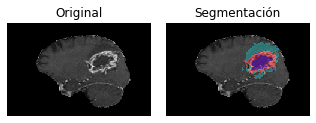

In [38]:
import matplotlib.pyplot as plt
sample = test_files[20]
print(sample)
img = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 4))
img_mask = os.path.join(paths["DATABASE_DIR"], create_file_name(sample, 1))
img = nib.load(img)
img_mask = nib.load("/media/bersek/56DAFC88DAFC65A1/BRATS/code/BraTS20_Training_045_seg.nii")
image = img.get_fdata()
image = image[::-1]
image_mask = img_mask.get_fdata()
image_mask = image_mask[::-1]

z = 105
y = 150
x = 140
threshold = 0.1
n1 =50
m1 = 240-(64-n1)

n2 =50
m2 = 240-(64-n2)

n3 =50
m3 = 240-(65-n3)

color1 = "rainbow"
color2 = "cool"
threshold = 0.1
image_mask[:,:,:][image_mask[:,:,:]< threshold] = np.nan

plt.figure(plt.figure(figsize=(6, 4)))
plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original")
plt.imshow(np.transpose(image[x,:,:],(1,0))[::-1], 'gray', interpolation='none')
#plt.imshow(np.transpose(image_mask[x,:,:],(1,0))[::-1], color2, interpolation='none', alpha=0.3)
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Segmentación")
plt.imshow(np.transpose(image[x,:,:],(1,0))[::-1], 'gray', interpolation='none')
plt.imshow(np.transpose(image_mask[x,:,:],(1,0))[::-1], color1, interpolation='none', alpha=0.4)




plt.savefig("test_{}.png".format(color1), dpi=1200, 
                transparent=True, 
                bbox_inches='tight')


plt.show()


In [33]:
image[x,:,:].shape

(240, 155)

In [82]:
image_mask[:,45:200,z].shape

(240, 155)